# Bonus-Track Assignment 2: Sequential MNIST classification task
Note: as a reference for keras tuner I used the documentation: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
import keras_tuner as kt
from keras.datasets import mnist
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

2023-05-10 17:31:15.696513: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 17:31:15.928214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 17:31:15.930833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 17:31:19.545579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the dataset

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()


print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


Plot the first digits

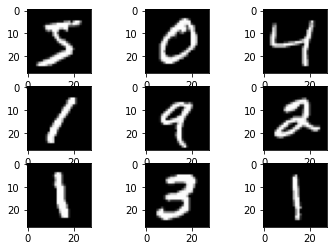

[5 0 4 1 9 2 1 3 1 4]


In [3]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

print(train_y[:10])

In [4]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
encoder.fit(test_y)

encoded__train_Y = encoder.transform(train_y)
encoded__test_Y = encoder.transform(test_y)

# convert integers to one hot encoded
y_train = np_utils.to_categorical(encoded__train_Y)
y_test = np_utils.to_categorical(encoded__test_Y)


flatten the input images into vectors

784


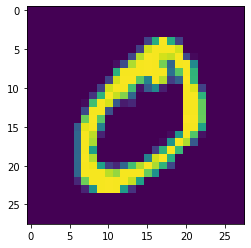

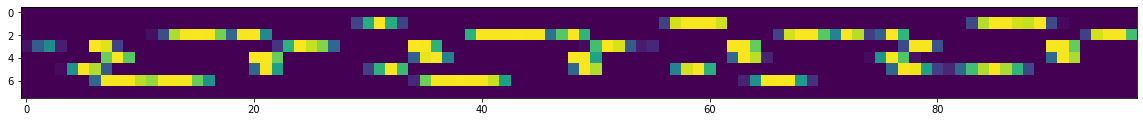

In [5]:
x_train = train_X.reshape(train_X.shape[0], -1)
x_test = test_X.reshape(test_X.shape[0], -1)
print(x_train.shape[1])

n = 1
x = train_X[n]
plt.imshow(x)
plt.show()
plt.figure(figsize = (20,15))
xx = (x_train[n]).reshape(8, int(len(x_train[n])/8))
plt.imshow(xx)




In [6]:
#reshape the data to feed the RNN
X_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
Y_train = np.reshape(y_train, (y_train.shape[0],1,y_train.shape[1]))
Y_train = y_train
X_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
Y_test = np.reshape(y_test, (y_test.shape[0],1,y_test.shape[1]))
Y_test = y_test
#check the shapes
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(60000, 784, 1)
(60000, 10)
(10000, 784, 1)
(10000, 10)


### Create the model
To do model selection, we actually create the "hypermodel", defining the hyperparameter search space as well as the architecture of the model.

In [7]:
bs = 200 #batch size

In [8]:
def model_architecture(lr, hidden_units, activation_h):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, activation=activation_h, input_shape=(bs,784,1), return_sequences=True, stateful = True, batch_input_shape=(bs,784,1))) 
    model.add(Flatten()),
    model.add(Dense(units=10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])
    return model

def create_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 10-100
    hidden_units = hp.Int('units',  min_value=10, max_value=100, step=10)

    #Tune the activation function of the hidden layer
    activation_h = hp.Choice("activation_h", ["linear","relu", "tanh"])

    # Tune the learning rate for the optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # call model-building code with the hyperparameter values.
    model = model_architecture( hidden_units = hidden_units, activation_h = activation_h, lr=lr
    )
    return model

Instantiate hyperparameter tuner

In [9]:
# use random search to find optimal hyperparameters
tuner = kt.RandomSearch(
                     hypermodel=create_model,
                     objective='val_accuracy',
                     max_trials=20,
                     overwrite=True,
                     directory='tuner',
                     project_name='tuner_rnn'
                     )

tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
activation_h (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Create a callback to stop training early after reaching a certain value for the validation loss.

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Train the model

In [11]:
tuner.search(X_train, Y_train, epochs=5, batch_size = bs, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
Completed hyperparameters search.\n
Otimal number of units of hidden layer = {best_hps.get('units')} \n
Optimal learning rate for the optimizer = {best_hps.get('learning_rate')} \n
Optimal activation function for the hidden layer = {best_hps.get('activation_h')} \n
""")


Trial 5 Complete [00h 04m 41s]
val_accuracy: 0.8838333487510681

Best val_accuracy So Far: 0.9470000267028809
Total elapsed time: 00h 41m 32s
INFO:tensorflow:Oracle triggered exit

Completed hyperparameters search.

Otimal number of units of hidden layer = 70 

Optimal learning rate for the optimizer = 0.01 

Optimal activation function for the hidden layer = relu 




Find the optimal number of epochs

In [12]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()
history = model.fit(X_train, Y_train, epochs=15, batch_size = bs, verbose=2, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (200, 784, 70)            5040      
                                                                 
 flatten_1 (Flatten)         (200, 54880)              0         
                                                                 
 dense_1 (Dense)             (200, 10)                 548810    
                                                                 
Total params: 553,850
Trainable params: 553,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
240/240 - 80s - loss: 19.0109 - accuracy: 0.8530 - val_loss: 0.2853 - val_accuracy: 0.9206 - 80s/epoch - 332ms/step
Epoch 2/15
240/240 - 77s - loss: 0.2854 - accuracy: 0.9188 - val_loss: 0.2693 - val_accuracy: 0.9263 - 77s/epoch - 322ms/step
Epoch 3/15
240/240 - 80s - loss: 0.2601 - accuracy: 0.9253 

Find best epoch:

In [13]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 8


Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [14]:
hypermodel = tuner.hypermodel.build(best_hps)
# Retrain the model
history = hypermodel.fit(X_train, Y_train,batch_size = bs, epochs=best_epoch, verbose=2, validation_split = 0.2).history

Epoch 1/8
240/240 - 78s - loss: 34.7828 - accuracy: 0.8511 - val_loss: 0.3456 - val_accuracy: 0.9069 - 78s/epoch - 324ms/step
Epoch 2/8
240/240 - 80s - loss: 0.2821 - accuracy: 0.9230 - val_loss: 0.2491 - val_accuracy: 0.9318 - 80s/epoch - 335ms/step
Epoch 3/8
240/240 - 74s - loss: 0.2390 - accuracy: 0.9326 - val_loss: 0.3331 - val_accuracy: 0.9124 - 74s/epoch - 309ms/step
Epoch 4/8
240/240 - 76s - loss: 0.2067 - accuracy: 0.9400 - val_loss: 0.2352 - val_accuracy: 0.9345 - 76s/epoch - 316ms/step
Epoch 5/8
240/240 - 77s - loss: 0.1799 - accuracy: 0.9475 - val_loss: 0.2585 - val_accuracy: 0.9308 - 77s/epoch - 321ms/step
Epoch 6/8
240/240 - 77s - loss: 0.1976 - accuracy: 0.9415 - val_loss: 0.2425 - val_accuracy: 0.9324 - 77s/epoch - 322ms/step
Epoch 7/8


### Make plots of the loss and validation loss

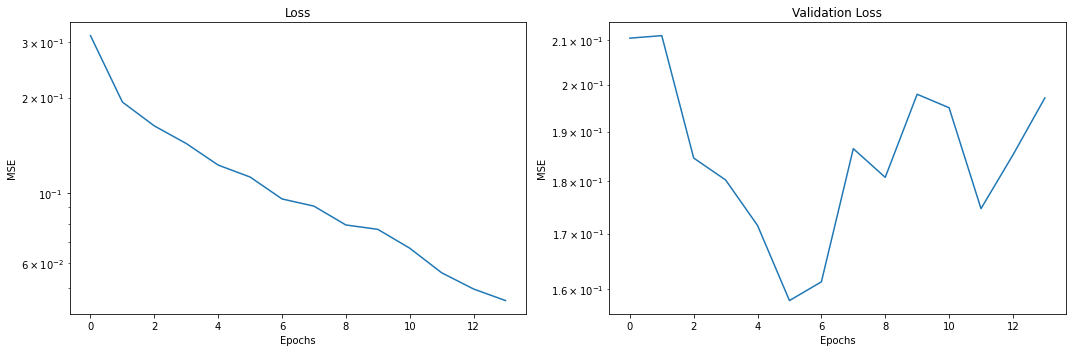

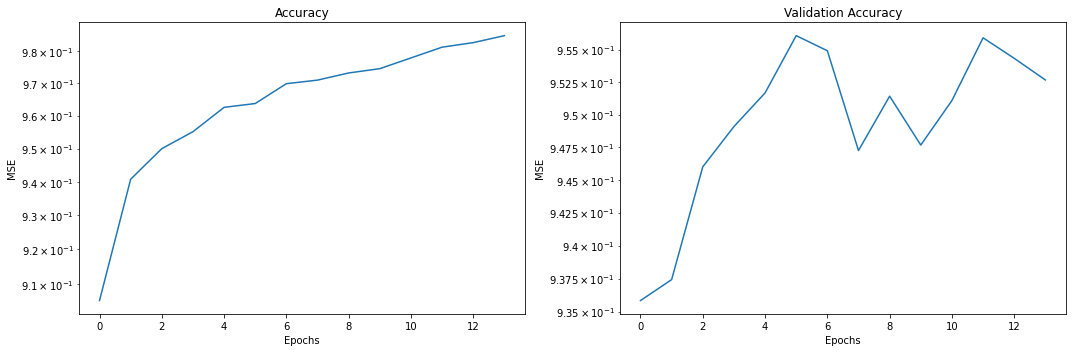

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')

plt.subplot(122)
plt.title('Validation Loss')
plt.plot(history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.tight_layout()

plt.savefig("plots/RNN_loss.pdf")


plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('Accuracy')
plt.plot(history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')

plt.subplot(122)
plt.title('Validation Accuracy')
plt.plot(history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.tight_layout()

plt.savefig("plots/RNN_loss.pdf")

plt.show()

Save the model

In [ ]:
hypermodel.save('keras_model_rnn')

INFO:tensorflow:Assets written to: keras_model_rnn/assets


INFO:tensorflow:Assets written to: keras_model_rnn/assets


Command to (eventually) load the saved model:

In [ ]:
#hypermodel = keras.models.load_model('keras_model_rnn')

### Plots of target and output signals over time

In [ ]:
scores = model.evaluate(X_test, Y_test,batch_size = bs, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
'''
#training
y = hypermodel.predict(X_train)
mse = hypermodel.evaluate(X_train, Y_train)[0]
t=np.arange(start=0,stop=len(X_train[0]), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'training - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,Y_train.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.legend()

plt.subplot(212)
plt.title('training (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],Y_train.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.legend()
plt.savefig("plots/RNN_training.pdf")


#validation
y = hypermodel.predict(X_valid)
mse = hypermodel.evaluate(X_valid, Y_valid)[0]
t=np.arange(start=0,stop=len(X_valid[0]), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'validation - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,Y_valid.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.legend()

plt.subplot(212)
plt.title('validation (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],Y_valid.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.legend()
plt.savefig("plots/RNN_validation.pdf")


#test
y = hypermodel.predict(X_test)
mse = hypermodel.evaluate(X_test, Y_test)[0]
t=np.arange(start=0,stop=len(Y_test[0]), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'test - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,Y_test.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.legend()

plt.subplot(212)
plt.title('test (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],Y_test.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.legend()
plt.savefig("plots/RNN_test.pdf")
'''


Accuracy: 95.60%


'\n#training\ny = hypermodel.predict(X_train)\nmse = hypermodel.evaluate(X_train, Y_train)[0]\nt=np.arange(start=0,stop=len(X_train[0]), step=1)\nplt.figure(figsize = (25,10))\nplt.subplot(211)\nplt.title(f\'training - MSE = {mse:e}\')\nplt.plot(t,y.ravel(), color = \'b\', linewidth= 0.4, label = \'output\')\nplt.plot(t,Y_train.ravel(), color = \'r\', linewidth= 0.4, linestyle = \'--\', label = \'target\')\nplt.legend()\n\nplt.subplot(212)\nplt.title(\'training (first 200 timesteps)\')\nplt.plot(t[:200],y.ravel()[:200], color = \'b\', linewidth= 0.4, label = \'output\')\nplt.plot(t[:200],Y_train.ravel()[:200], color = \'r\', linewidth= 0.4, linestyle = \'--\', label = \'target\')\nplt.legend()\nplt.savefig("plots/RNN_training.pdf")\n\n\n#validation\ny = hypermodel.predict(X_valid)\nmse = hypermodel.evaluate(X_valid, Y_valid)[0]\nt=np.arange(start=0,stop=len(X_valid[0]), step=1)\nplt.figure(figsize = (25,10))\nplt.subplot(211)\nplt.title(f\'validation - MSE = {mse:e}\')\nplt.plot(t,y.ra